In [ ]:
cd DeOldify

In [ ]:
!pip install -r requirements-colab.txt

In [3]:
#NOTE:  This must be the first call in order to work properly!
from deoldify import device
from deoldify.device_id import DeviceId
#choices:  CPU, GPU0...GPU7
device.set(device=DeviceId.GPU0)

<DeviceId.GPU0: 0>

In [ ]:
from deoldify.visualize import *
plt.style.use('dark_background')
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*?Your .*? set is empty.*?")

In [5]:
# !pip install scikit-image lpips torch torchvision

In [ ]:
# Load the trained generator model
learn = gen_inference_deep(
    image_path=Path('./data/custom_dataset/bandw/test/00004_photometric.jpeg'),
    root_folder=Path('./data/custom_dataset/bandw'),
    weights_name='ArtisticModel_gen_0',
    sz=128  # or whatever size you trained on
)


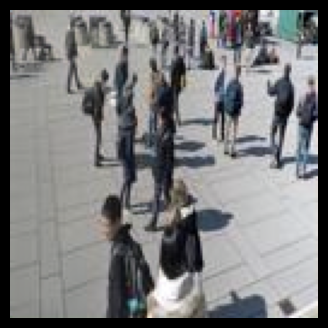

In [29]:
from fastai.vision import open_image, Image
from pathlib import Path
from PIL import Image as PILImage
import matplotlib.pyplot as plt
import torch

# Load input image
# img_path = Path('./data/custom_dataset/bandw/test/00004_aliasing.jpeg')

img_path = Path('./data/custom_dataset/bandw/test/32780_intensity_nonuniformity.jpeg')
img_pil = PILImage.open(img_path).convert('RGB').resize((128, 128), resample=PILImage.BICUBIC)
img_pil.save(img_path)
img = open_image(img_path)
# Match device
device = next(learn.model.parameters()).device
xb = img.data.unsqueeze(0).to(device)
yb = img.data.unsqueeze(0).to(device)

# Inference
pred = learn.pred_batch(batch=(xb, yb))[0]

pred_image = pred.detach().cpu().clamp(0, 1)

# Convert [C, H, W] → [H, W, C]
pred_image_np = pred_image.permute(1, 2, 0).numpy()

# Display using matplotlib
plt.figure(figsize=(4, 4))
plt.imshow(pred_image_np)
plt.axis('off')
plt.show()


In [11]:
from fastai.vision import open_image, Image
from PIL import Image as PILImage
from pathlib import Path
import os

# Input folder: grayscale test images
input_folder = Path('./data/custom_dataset/bandw/test/')

# Output folder: colorized/generated images
output_folder = Path('./gen_images/')
output_folder.mkdir(parents=True, exist_ok=True)

# Get device (CPU or GPU)
device = next(learn.model.parameters()).device

# Loop over all images in test folder
for file in os.listdir(input_folder):
    if not file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.dcm')):
        continue  # skip non-image files

    try:
        # Load input image
        img_path = input_folder / file
        img_pil = PILImage.open(img_path).convert('RGB').resize((128, 128), resample=PILImage.BICUBIC)
        img_pil.save(img_path)  # overwrite or save to new path if needed

        img = open_image(img_path)  # then proceed as usual

        # Prepare batch
        xb = img.data.unsqueeze(0).to(device)
        yb = img.data.unsqueeze(0).to(device)

        # Inference
        pred = learn.pred_batch(batch=(xb, yb))[0]

        # Convert to fastai Image and save
        out_img = Image(pred)
        out_img.save(output_folder / file)


    except Exception as e:
        print(f"⚠️ Failed on {file}: {e}")


In [15]:
from pathlib import Path
from PIL import Image

# Path to the images
gt_path = Path('./data/custom_dataset/norm/test/')
target_size = (128, 128)

# Allowed image extensions
allowed_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.dcm'}

# Resize each image
for img_path in gt_path.rglob('*'):
    if img_path.suffix.lower() in allowed_exts:
        try:
            with Image.open(img_path) as img:
                resized = img.resize(target_size, Image.LANCZOS)
                resized.save(img_path)
        except Exception as e:
            print(f"Failed to process {img_path.name}: {e}")


In [ ]:
import os
from pathlib import Path
from skimage.io import imread
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import lpips
import torch
import torchvision.transforms as transforms
from PIL import Image

# Set path
gt_path = Path('./data/custom_dataset/norm/test/')   # ground truth images
pred_path = Path('./gen_images/')  # restored/generated images

# LPIPS model (Alex, VGG also available)
lpips_model = lpips.LPIPS(net='alex')
lpips_model.eval()

# Image transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # optional: resize for LPIPS consistency
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Collect metrics
results = []

for file in os.listdir(gt_path):
    gt_img_path = gt_path / file
    pred_img_path = pred_path / file

    if not pred_img_path.exists():
        print(f"Missing prediction for: {file}")
        continue

    # Load grayscale or RGB
    gt_img = imread(gt_img_path)
    pred_img = imread(pred_img_path)

    if gt_img.ndim == 2:
        multichannel = False
    else:
        multichannel = True

    # --- SSIM and PSNR ---
    ssim_score = ssim(gt_img, pred_img, data_range=255, channel_axis=-1 if multichannel else None)
    psnr_score = psnr(gt_img, pred_img, data_range=255)

    # --- LPIPS ---
    img0 = transform(Image.open(gt_img_path).convert("RGB")).unsqueeze(0)
    img1 = transform(Image.open(pred_img_path).convert("RGB")).unsqueeze(0)
    with torch.no_grad():
        lpips_score = lpips_model(img0, img1).item()

    results.append({
        'filename': file,
        'SSIM': ssim_score,
        'PSNR': psnr_score,
        'LPIPS': lpips_score
    })

# Print average
ssim_avg = sum(r['SSIM'] for r in results) / len(results)
psnr_avg = sum(r['PSNR'] for r in results) / len(results)
lpips_avg = sum(r['LPIPS'] for r in results) / len(results)

print(f"\nAverage SSIM: {ssim_avg:.4f}")
print(f"Average PSNR: {psnr_avg:.2f} dB")
print(f"Average LPIPS: {lpips_avg:.4f}")


In [ ]:
import os
from pathlib import Path
from skimage.io import imread
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import lpips
import torch
import torchvision.transforms as transforms
from PIL import Image
from collections import defaultdict

# Distortion groups
distortion_groups = [
    "aliasing", "barrel_distortion", "beam_hardening", "blur", "chromatic_aberration",
    "color_cast", "color_shift", "compression_artifacts", "gaussian_blur", "intensity_nonuniformity",
    "jpeg2000_compression", "jpeg_compression", "low_resolution", "metal_artifacts", "motion_artifacts",
    "mustache_distortion", "partial_volume", "photometric", "pincushion_distortion", "rolling_shutter",
    "saturated", "structural_artifacts", "_vignetting", "white_gaussian_noise"
]

# Set paths
pred_path = Path('./data/custom_dataset/bandw/test/')   # prediction/restored
gt_path = Path('./data/custom_dataset/norm/test/')      # ground truth

# LPIPS model
lpips_model = lpips.LPIPS(net='alex')
lpips_model.eval()

# Image transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Grouped results
grouped_results = defaultdict(list)

# Process files
for file in os.listdir(gt_path):
    gt_img_path = gt_path / file
    pred_img_path = pred_path / file

    if not pred_img_path.exists():
        print(f"Missing prediction for: {file}")
        continue

    # Identify distortion group
    matched_group = next((g for g in distortion_groups if g in str(gt_img_path)), None)
    if not matched_group:
        print(f"No group matched for: {file}")
        continue

    # Load images
    gt_img = imread(gt_img_path)
    pred_img = imread(pred_img_path)
    multichannel = gt_img.ndim == 3

    # SSIM and PSNR
    ssim_score = ssim(gt_img, pred_img, data_range=255, channel_axis=-1 if multichannel else None)
    psnr_score = psnr(gt_img, pred_img, data_range=255)

    # LPIPS
    img0 = transform(Image.open(gt_img_path).convert("RGB")).unsqueeze(0)
    img1 = transform(Image.open(pred_img_path).convert("RGB")).unsqueeze(0)
    with torch.no_grad():
        lpips_score = lpips_model(img0, img1).item()

    grouped_results[matched_group].append({
        'SSIM': ssim_score,
        'PSNR': psnr_score,
        'LPIPS': lpips_score
    })

# Report averages per group
for group, metrics in grouped_results.items():
    ssim_avg = sum(m['SSIM'] for m in metrics) / len(metrics)
    psnr_avg = sum(m['PSNR'] for m in metrics) / len(metrics)
    lpips_avg = sum(m['LPIPS'] for m in metrics) / len(metrics)
    print(f"\nGroup: {group}")
    print(f"  Average SSIM: {ssim_avg:.4f}")
    print(f"  Average PSNR: {psnr_avg:.2f} dB")
    print(f"  Average LPIPS: {lpips_avg:.4f}")
